### Get Gesture Notebook
1) Loads the model  <br />
2) takes 5 snaps    <br />
3) predicts them    <br />
4) prints the most common gesture out of the 5  <br />

In [1]:
import csv
import copy
import itertools
import cv2 as cv
import mediapipe as mp
from model import KeyPointClassifier
from statistics import mode
import matplotlib.pyplot as plt

In [2]:
def calc_landmark_list(image, landmarks):
    image_width, image_height = image.shape[1], image.shape[0]

    landmark_point = []

    # Keypoint
    for _, landmark in enumerate(landmarks.landmark):
        landmark_x = min(int(landmark.x * image_width), image_width - 1)
        landmark_y = min(int(landmark.y * image_height), image_height - 1)
        # landmark_z = landmark.z

        landmark_point.append([landmark_x, landmark_y])

    return landmark_point

In [3]:
def pre_process_landmark(landmark_list):
    temp_landmark_list = copy.deepcopy(landmark_list)

    # Convert to relative coordinates
    base_x, base_y = 0, 0
    for index, landmark_point in enumerate(temp_landmark_list):
        if index == 0:
            base_x, base_y = landmark_point[0], landmark_point[1]

        temp_landmark_list[index][0] = temp_landmark_list[index][0] - base_x
        temp_landmark_list[index][1] = temp_landmark_list[index][1] - base_y

    # Convert to a one-dimensional list
    temp_landmark_list = list(
        itertools.chain.from_iterable(temp_landmark_list))

    # Normalization
    max_value = max(list(map(abs, temp_landmark_list)))

    def normalize_(n):
        return n / max_value

    temp_landmark_list = list(map(normalize_, temp_landmark_list))

    return temp_landmark_list


In [4]:
# Argument parsing #################################################################
cap_device = 0
cap_width = 960
cap_height = 540
use_static_image_mode = True
min_detection_confidence = 0.7
min_tracking_confidence = 0.5
use_brect = True


In [5]:
# Camera preparation ###############################################################
cap = cv.VideoCapture(cap_device)


In [6]:
# Model load #############################################################
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=use_static_image_mode,
    max_num_hands=1,
    min_detection_confidence=min_detection_confidence,
    min_tracking_confidence=min_tracking_confidence,
)

keypoint_classifier = KeyPointClassifier()


In [7]:
# Read labels ###########################################################
with open('model/keypoint_classifier/keypoint_classifier_label.csv',
            encoding='utf-8-sig') as f:
    keypoint_classifier_labels = csv.reader(f)
    keypoint_classifier_labels = [
        row[0] for row in keypoint_classifier_labels
    ]

keypoint_classifier_labels

['Back', 'Advance', 'Right', 'Left', 'Up', 'Down']

['Up', 'Up', 'Up', 'Up', 'Up']


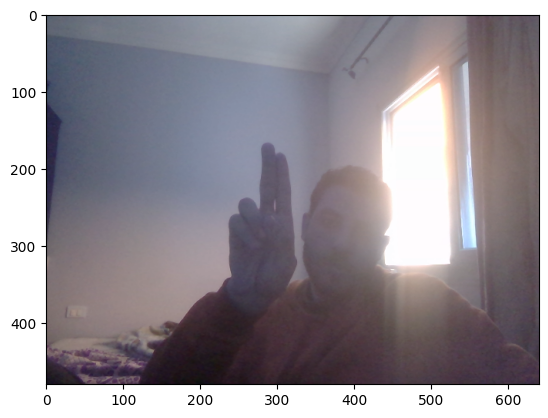

In [8]:
iteration = 0 
output_list = []
while iteration < 5:
    iteration = iteration + 1
    # Camera capture #####################################################
    ret, image = cap.read()
    if not ret:
        break
    image = cv.flip(image, 1)  # Mirror display
    debug_image = copy.deepcopy(image)
    plt.imshow(debug_image)
    # Detection implementation #############################################################
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    image.flags.writeable = False
    results = hands.process(image)
    image.flags.writeable = True

    #  ####################################################################
    if results.multi_hand_landmarks is not None:
        for hand_landmarks, handedness in zip(results.multi_hand_landmarks,
                                                results.multi_handedness):
            # Landmark calculation
            landmark_list = calc_landmark_list(debug_image, hand_landmarks)

            # Conversion to relative coordinates / normalized coordinates
            pre_processed_landmark_list = pre_process_landmark(
                landmark_list)
            
            # Hand sign classification
            hand_sign_id = keypoint_classifier(pre_processed_landmark_list)
            output_list.append(keypoint_classifier_labels[hand_sign_id])
    else:
        output_list.append('None')


print(output_list)

In [9]:
print(mode(output_list))

Up


In [10]:
cap.release()